# EnsembleUSegNet
Since the Ensemble USegNet is an ensemble model made up of 2D U-Seg-Nets, majority of this Jupyter notebook will contain the following processes about 2D U-Seg-Net:

* Number of parameters
* Hyperparameter Tuning 
* Training and Test Evaluation

In [4]:
# Import necessary libraries
import numpy as np
import torchio as tio
from torchinfo import summary

# Custom modules containing my implementation of the models with PyTorch and also some helper functions
from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import *
from data_utils.dataset import *

In [5]:
sample_unet = SingleViewUSegNet()
summary(sample_unet, (2,1,40,56))

Layer (type:depth-idx)                   Output Shape              Param #
SingleViewUSegNet                        --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [2, 32, 40, 56]           --
│    │    └─Conv2d: 3-1                  [2, 32, 40, 56]           320
│    │    └─BatchNorm2d: 3-2             [2, 32, 40, 56]           64
│    │    └─ReLU: 3-3                    [2, 32, 40, 56]           --
├─MaxPool2d: 1-3                         [2, 32, 20, 28]           --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-2                   [2, 64, 20, 28]           --
│    │    └─Conv2d: 3-4                  [2, 64, 20, 28]           18,496
│    │    └─BatchNorm2d: 3-5             [2, 64, 20, 28]           128
│    │   

#### Train-test split

In [3]:
train_subj, test_subj = get_train_test_subjects(
    'harp_metadata.csv',  # change accordingly to where this file is stored
    'znorm_cropped_imgs',  # change accordingly to where this folder is stored
    42, # fix the split
    True
)

#### LR Range Test for 2D U-Seg-Nets

As explained in: https://arxiv.org/pdf/1506.01186.pdf (For conciseness, we only show for the sagittal models of the left and right hippocampi)

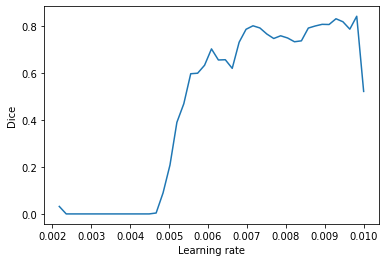

In [11]:
lr_test_2dunet = SingleViewUSegNet()
lr_test_hist_2d = lr_range_test_2d(
    model=lr_test_2dunet,
    view=0,  # change this according to the desired view
    dir_name='znorm_cropped_imgs',
    brain_side='L',
    train_ids=train_subj,
    batch_size=2,
    end_lr=0.01
)

lr_range_plot(lr_test_hist_2d, 'metric')

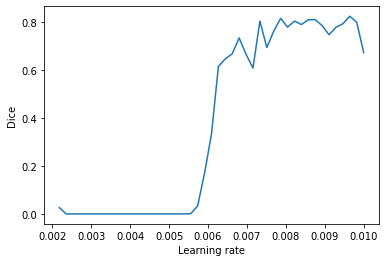

In [18]:
lr_test_2dunet = SingleViewUSegNet()
lr_test_hist_2d = lr_range_test_2d(
    model=lr_test_2dunet,
    view=0,  # change this according to the desired view
    dir_name='znorm_cropped_imgs',
    brain_side='R',
    train_ids=train_subj,
    batch_size=2,
    end_lr=0.01
)

lr_range_plot(lr_test_hist_2d, 'metric')

#### Hyperparameter Tuning for 2D U-Seg-Nets

For conciseness of this notebook, we will only use one experiment cell each for the left and right hippocampus respectively. Note that in this thesis, we tuned for a total of six U-Seg-Nets, with three views each for the left and right hippocampus. Tuning is performed by changing the batch_size and num_epochs function arguments respectively.

However, I strongly recommend to not run these cells because they will take up significant time especially if you do not have a high memory GPU.

The cross validation plots ran in our experiments can be obtained by loading the cross validation histories from the "saved_histories" folder.

In [ ]:
# DO NOT run unless connected to GPU
trainval_hist_2d_L0_b2_e50 = skfcv_train_2d_model(
    model_class = SingleViewUSegNet,
    view=0,
    dir_name='znorm_cropped_imgs',
    brain_side='L',
    meta_file='harp_metadata.csv',
    train_ids=train_subj,
    batch_size=4,
    num_epochs=50,
    max_learn_rate=0.009,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_2d_L0_b2_e50.npz', **trainval_hist_2d_L0_b2_e50)

In [ ]:
# DO NOT run unless connected to GPU
trainval_hist_2d_R0_b2_e50 = skfcv_train_2d_model(
    model_class = SingleViewUSegNet,
    view=0,
    dir_name='znorm_cropped_imgs',
    brain_side='R',
    meta_file='harp_metadata.csv',
    train_ids=train_subj,
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.009,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_2d_R0_b2_e50.npz', **trainval_hist_2d_R0_b2_e50)

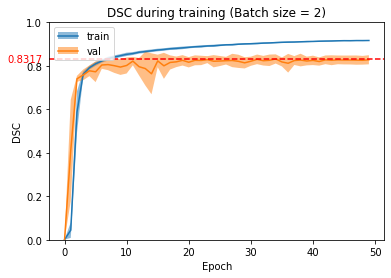

Per epoch training time = 8.1750855


In [8]:
## Plotting of cross validation outputs from saved histories

model_type='2d'
brain_side='L0'
batch_size=2
num_epoch=50

trainval_hist = np.load('saved_histories/{0}_{2}/trainval_hist_{1}_{2}_b{3}_e{4}.npz'.format(
    model_type.upper(), 
    model_type,
    brain_side,
    batch_size,
    num_epoch
)
                       )

trainval_hist = dict(trainval_hist)

plot_val_per_epoch(trainval_hist,
                   [('train_dice_per_epoch', 'train'), ('val_dice_per_epoch', 'val')],
                  'DSC',
                  'DSC during training (Batch size = {0})'.format(batch_size),
                  (0.0, 1))

print("Per epoch training time = {0}".format(get_train_time(trainval_hist, per_epoch=True, kfcv=True)))

##### Hyperparameter Tuning Results

| Model | LR$_{max}$ | Mini-batch size | Number of epochs |
| :-: | :-: | :-: | :-: |
| U-Seg-Net$_{L0}$ | 0.009 | 160 | 20 |
| U-Seg-Net$_{L1}$ | 0.008 | 224 | 18 |
| U-Seg-Net$_{L2}$ | 0.0085 | 288 | 22 |
| U-Seg-Net$_{R0}$ | 0.009 | 80 | 25 |
| U-Seg-Net$_{R1}$ | 0.008 | 224 | 25 |
| U-Seg-Net$_{R2}$ | 0.008 | 288 | 20 |

#### Training on full training data and Evaluation

Strongly suggest to not uncomment and run the training cell if you are not using a device with GPU access (to prevent any crashes). The models trained have been saved under the "saved_models" folder as .pth files. Load those instead to prevent any errors due to absence of GPU or a GPU with insufficient memory.

**NOTE:** To keep this notebook concise, we only show the test performances of the U-Seg-Nets and Ensemble USegNet corresponding to the left hippocampus. However, the saved training histories and models can also be found in the saved_histories and saved_models folder respectively.

In [19]:
usegnet_L0 = SingleViewUSegNet()  # sagittal
usegnet_L1 = SingleViewUSegNet()  # coronal
usegnet_L2 = SingleViewUSegNet()  # axial

In [ ]:
# WARNING, running without a 16GB memory GPU has not been tested, 
# highly recommended to skip this cell and load the saved models to prevent any system errors
# due to hardware constraints.

# sag_train_history_L = train_2d_model(
#     model=usegnet_L0,
#     view=0,
#     dir_name='znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=4,  # corresponds to number of subjects
#     num_epochs=20,
#     max_learn_rate=0.009
# )
# coro_train_history_L = train_2d_model(
#     model=usegnet_L1,
#     view=1,
#     dir_name='znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=2,  # corresponds to number of subjects
#     num_epochs=18,
#     max_learn_rate=0.008
# )

# axial_train_history_L = train_2d_model(
#     model=usegnet_L2,
#     view=2,
#     dir_name='znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=4,  # corresponds to number of subjects
#     num_epochs=22,
#     max_learn_rate=0.0085
# )

# np.savez('final_2D_L0_trainhist.npz', **sag_train_history_L)
# save_model(usegnet_L0, save_path='final_2D_L0.pth')

# np.savez('final_2D_L1_trainhist.npz', **coro_train_history_L)
# save_model(usegnet_L1, save_path='final_2D_L1.pth')

# np.savez('final_2D_L2_trainhist.npz', **axial_train_history_L)
# save_model(usegnet_L2, save_path='final_2D_L2.pth')

In [ ]:
# Load the saved models
usegnet_L0.load_state_dict(torch.load('saved_models/final_2D_L0.pth'))
usegnet_L0.to('cuda')

usegnet_L1.load_state_dict(torch.load('saved_models/final_2D_L1.pth'))
usegnet_L1.to('cuda')

usegnet_L2.load_state_dict(torch.load('saved_models/final_2D_L2.pth'))
usegnet_L2.to('cuda')

In [22]:
# Evaluation on test data
# Best to run on a machine with GPU as well

test_loss_L0, test_dsc_L0, test_prec_L0, test_recall_L0 = start_2d_eval(model=usegnet_L0,
                                                                        view=0,
                                                                        dir_name='znorm_cropped_imgs',
                                                                        brain_side='L', 
                                                                        test_ids=test_subj,
                                                                        batch_size=1, 
                                                                        verbose=False)


test_loss_L1, test_dsc_L1, test_prec_L1, test_recall_L1 = start_2d_eval(model=usegnet_L1,
                                                                        view=1,
                                                                        dir_name='znorm_cropped_imgs',
                                                                        brain_side='L', 
                                                                        test_ids=test_subj,
                                                                        batch_size=1,
                                                                        verbose=False)


test_loss_L2, test_dsc_L2, test_prec_L2, test_recall_L2 = start_2d_eval(model=usegnet_L2,
                                                                        view=2, 
                                                                        dir_name='znorm_cropped_imgs',
                                                                        brain_side='L', 
                                                                        test_ids=test_subj,
                                                                        batch_size=1, 
                                                                        verbose=False)
print("## Left hippocampus, sagittal model ##")
print("Test Loss: {0:.5f}, Test DSC: {1:.5f}, Test Precision: {2:.5f}, Test Recall: {3:.5f}".format(
    test_loss_L0,
    test_dsc_L0,
    test_prec_L0,
    test_recall_L0)
     )
print('## Left hippocampus, coronal model ##')
print("Test Loss: {0:.5f}, Test DSC: {1:.5f}, Test Precision: {2:.5f}, Test Recall: {3:.5f}".format(
    test_loss_L1,
    test_dsc_L1,
    test_prec_L1,
    test_recall_L1)
     )
print("## Left hippocampus, axial model ##")
print("Test Loss: {0:.5f}, Test DSC: {1:.5f}, Test Precision: {2:.5f}, Test Recall: {3:.5f}".format(
    test_loss_L2,
    test_dsc_L2,
    test_prec_L2,
    test_recall_L2)
     )

## Left hippocampus, sagittal model ##
Test Loss: 0.01304, Test DSC: 0.83427, Test Precision: 0.85802, Test Recall: 0.82694
## Left hippocampus, coronal model ##
Test Loss: 0.01440, Test DSC: 0.83976, Test Precision: 0.82444, Test Recall: 0.86088
## Left hippocampus, axial model ##
Test Loss: 0.01495, Test DSC: 0.82825, Test Precision: 0.86929, Test Recall: 0.79860


In the next cell, the three models above are ensembled together to give the final segmentation mask for EnsembleUSegNet$_L$. Note that ad_test_subj, mci_test_subj and cn_test_subj are the test subjects who have AD, MCI and CN respectively. Change the test_ids argument in the start_ensemble_eval function to any of these in order to get the corresponding test performance on a specific disease stage.

In [23]:
# Ensembling the models together to get final test performance

ad_test_subj = ['123_S_0091','098_S_0149','067_S_0812',
               '023_S_0916','020_S_0213','018_S_4696',
               '011_S_0010','005_S_1341','002_S_0938']
mci_test_subj = ['123_S_1300','100_S_0006','094_S_1293',
                 '012_S_1292','007_S_0128','005_S_0448',
                 '003_S_0908','002_S_0782']
cn_test_subj = ['127_S_0259','100_S_0015','032_S_0479',
                '018_S_0425','010_S_0419','010_S_0067',
                '002_S_0413','002_S_0295']

mean_dice, mean_precision, mean_recall = start_ensemble_eval(
    model1=usegnet_L0,
    model2=usegnet_L1,
    model3=usegnet_L2,
    dir_name='znorm_cropped_imgs',
    brain_side='L',
    test_ids=test_subj,
    batch_size=1,
    verbose=False
)

print("## Left hippocampus, EnsembleUSegNet ##")
print("Test DSC: {0:.5f}, Test Precision: {1:.5f}, Test Recall: {2:.5f}".format(
    mean_dice,
    mean_precision,
    mean_recall)
     )

## Left hippocampus, EnsembleUSegNet ##
Test DSC: 0.86843, Test Precision: 0.88653, Test Recall: 0.85543


#### Generate predicted segmentation masks

The ensemble_model_predict function generates a new NIfTI file that contains the predicted hippocampus segmentation mask from the EnsembleUSegNet model. The code in the below cell was used to generate the prediction for subject 011_S_0010's left hippocampus using the EnsembleUSegNet. It is stored inside the folder 'znorm_cropped_imgs/011_S_0010/' with the file name 'E_PRED_LH_011_S_0010.nii'.

This segmentation can be interactively visualized using medical imaging software. In this thesis, ITK-Snap was used (http://www.itksnap.org/pmwiki/pmwiki.php) for visualization purposes, however other software such as FSL and FreeSurfer should work fine as well.

In [ ]:
sag_net = SingleViewUSegNet()
coro_net = SingleViewUSegNet()
axial_net = SingleViewUSegNet()

ensemble_model_predict(
    model1=sag_net,
    model2=coro_net,
    model3=axial_net,
    dir_name='znorm_cropped_imgs',
    subj_id='011_S_0010',
    brain_side='L',
    model_file=['saved_models/final_2D_L0.pth', 
                'saved_models/final_2D_L1.pth', 
                'saved_models/final_2D_L2.pth']
)